In [1]:
%pip install typing-extensions --upgrade
%pip install librosa --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/IoT_Repo/Models

Mounted at /content/gdrive
/content/gdrive/MyDrive/IoT_Repo/Models


In [3]:
#@title

import time
from ParticipantLab import ParticipantLab as parti
import numpy as np
import tensorflow as tf
import sys
import pickle
import os
import copy

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,accuracy_score
import matplotlib.pyplot as plt
import itertools
import csv

from sklearn import metrics
from enum import Enum
import librosa.display
import sys
from scipy import stats 
import datetime
from scipy.fftpack import dct
import pickle as cPickle


#from models import AttendDiscriminate_MotionAudio
from models import AttendDiscriminate_MotionAudio_CNN14_Concatenate
import torch
torch.backends.cudnn.benchmark=True
torch.manual_seed(1)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
from utils_ import plotCNNStatistics

import random
torch.backends.cudnn.deterministic = True
random.seed(1)
# torch.manual_seed(1)
# torch.cuda.manual_seed(1)
# np.random.seed(1)


from sklearn import metrics

from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.tensorboard import SummaryWriter

from models import create, StatisticsContainer
from utils.utils import paint, Logger, AverageMeter
from utils.utils_plot import plot_confusion
from utils.utils_pytorch import (
    get_info_params,
    get_info_layers,
    init_weights_orthogonal,
)
from utils.utils_mixup import mixup_data, MixUpLoss, mixup_data_AudioMotion
from utils.utils_centerloss import compute_center_loss, get_center_delta

import warnings

warnings.filterwarnings("ignore")


In [4]:
#@title
#LOPO

def model_train(model, dataset, dataset_val, args):
    print(paint("[STEP 4] Running HAR training loop ..."))

    logger = SummaryWriter(log_dir=os.path.join(model.path_logs, "train"))
    logger_val = SummaryWriter(log_dir=os.path.join(model.path_logs, "val"))

    loader = DataLoader(dataset, args['batch_size'], True, pin_memory=True)
    loader_val = DataLoader(dataset_val, args['batch_size'], False, pin_memory=True)

    criterion = nn.CrossEntropyLoss(reduction="mean").cuda()

    params = filter(lambda p: p.requires_grad, model.parameters())

    if args['optimizer'] == "Adam":
        optimizer = optim.Adam(params, lr=args['lr'])
    elif args['optimizer'] == "RMSprop":
        optimizer = optim.RMSprop(params, lr=args['lr'])

    if args['lr_step'] > 0:
        scheduler = optim.lr_scheduler.StepLR(
            optimizer, step_size=args['lr_step'], gamma=args['lr_decay']
        )

    if args['init_weights'] == "orthogonal":
        print(paint("[-] Initializing weights (orthogonal)..."))
        model.apply(init_weights_orthogonal)

    metric_best = 0.0
    start_time = time.time()
    for epoch in range(args['epochs']):
        print("--" * 50)
        print("[-] Learning rate: ", optimizer.param_groups[0]["lr"])
        train_one_epoch(model, loader, criterion, optimizer, epoch, args)
        loss, acc, fm, rm, pm, fw = eval_one_epoch(
            model, loader, criterion, epoch, logger, args
        )
        loss_val, acc_val, fm_val, rm_val, pm_val, fw_val = eval_one_epoch(
            model, loader_val, criterion, epoch, logger_val, args
        )

        print(
            paint(
                f"[-] Epoch {epoch}/{args['epochs']}"
                f"\tTrain loss: {loss:.2f} \tacc: {acc:.2f}(%)\tfm: {fm:.2f}(%)\trm: {rm:.2f}(%)\tpm: {pm:.2f}(%)\tfw: {fw:.2f}(%)"
            )
        )

        print(
            paint(
                f"[-] Epoch {epoch}/{args['epochs']}"
                f"\tVal loss: {loss_val:.2f} \tacc: {acc_val:.2f}(%)\tfm: {fm_val:.2f}(%)\trm: {rm_val:.2f}(%)\tpm: {pm_val:.2f}(%)\tfw: {fw_val:.2f}(%)"
            )
        )

        checkpoint = {
            "model_state_dict": model.state_dict(),
            "optim_state_dict": optimizer.state_dict(),
            "criterion_state_dict": criterion.state_dict(),
            "random_rnd_state": random.getstate(),
            "numpy_rnd_state": np.random.get_state(),
            "torch_rnd_state": torch.get_rng_state(),
        }

        metric = fm_val
        if metric >= metric_best:
            print(paint(f"[*] Saving checkpoint... ({metric_best}->{metric})", "blue"))
            metric_best = metric
            torch.save(
                checkpoint, os.path.join(model.path_checkpoints, "checkpoint_best.pth")
            )


        # if epoch % 20 == 0:
        #     torch.save(
        #         checkpoint,
        #         os.path.join(model.path_checkpoints, f"checkpoint_{epoch}.pth"),
        #     )

        if args['lr_step'] > 0:
            scheduler.step()

        trainLoss = {'Trainloss': loss}
        args['statistics'].append(epoch, trainLoss, data_type='Trainloss')
        valLoss = {'Testloss': loss_val}
        args['statistics'].append(epoch, valLoss, data_type='Testloss')
        test_f1 = {'test_f1':fm}
        args['statistics'].append(epoch, test_f1, data_type='test_f1')

        args['statistics'].dump()

    elapsed = round(time.time() - start_time)
    elapsed = str(datetime.timedelta(seconds=elapsed))

    print(paint(f"[STEP 4] Finished HAR training loop (h:m:s): {elapsed}"))
    print(paint("--" * 50, "blue"))

def train_one_epoch(model, loader, criterion, optimizer, epoch, args):

    losses = AverageMeter("Loss")
    model.train()

    for batch_idx, (data, data_a, target) in enumerate(loader):
        data = data.cuda()
        data_a = data_a.cuda()
        target = target.view(-1).cuda()

        centers = model.centers

        if args['mixup']:
            data, data_a, y_a_y_b_lam = mixup_data_AudioMotion(data, data_a, target, args['alpha'])

        z, logits = model(data, data_a)

        if args['mixup']:
            criterion = MixUpLoss(criterion)
            loss = criterion(logits, y_a_y_b_lam)
        else:
            loss = criterion(logits, target)

        center_loss = compute_center_loss(z, centers, target)
        loss = loss + args['beta'] * center_loss

        losses.update(loss.item(), data.shape[0])

        optimizer.zero_grad()
        loss.backward()
        if args['clip_grad'] > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), args['clip_grad'])
        optimizer.step()

        center_deltas = get_center_delta(z.data, centers, target, args['lr_cent'])
        model.centers = centers - center_deltas

        if batch_idx % args['print_freq']== 0:
            print(f"[-] Batch {batch_idx}/{len(loader)}\t Loss: {str(losses)}")

        if args['mixup']:
            criterion = criterion.get_old()

def eval_one_epoch(model, loader, criterion, epoch, logger, args):

    losses = AverageMeter("Loss")
    y_true, y_pred = [], []
    model.eval()

    with torch.no_grad():
        for batch_idx, (data, data_a, target) in enumerate(loader):
            data = data.cuda()
            data_a = data_a.cuda()
            target = target.cuda()

            z, logits = model(data,data_a)
            loss = criterion(logits, target.view(-1))
            losses.update(loss.item(), data.shape[0])

            probabilities = nn.Softmax(dim=1)(logits)
            _, predictions = torch.max(probabilities, 1)

            y_pred.append(predictions.cpu().numpy().reshape(-1))
            y_true.append(target.cpu().numpy().reshape(-1))

    y_true = np.concatenate(y_true, 0)
    y_pred = np.concatenate(y_pred, 0)

    acc = 100.0 * metrics.accuracy_score(y_true, y_pred)
    fm = 100.0 * metrics.f1_score(y_true, y_pred, average="macro")
    rm = 100.0* metrics.recall_score(y_true, y_pred, average="macro")
    pm = 100.0*metrics.precision_score(y_true, y_pred, average="macro")
    fw = 100.0 * metrics.f1_score(y_true, y_pred, average="weighted")

    if logger:
        logger.add_scalars("Loss", {"CrossEntropy": losses.avg}, epoch)
        logger.add_scalar("Acc", acc, epoch)
        logger.add_scalar("Fm", fm, epoch)
        logger.add_scalar("Rm", rm, epoch)
        logger.add_scalar("Pm", pm, epoch)
        logger.add_scalar("Fw", fw, epoch)

    '''
    if epoch % 50 == 0 or not args['train_mode']:
        plot_confusion(
            y_true,
            y_pred,
            os.path.join(model.path_visuals, f"cm/{args['participant']}"),
            epoch,
            class_map=args['class_map'],
        )
    '''

    return losses.avg, acc, fm, rm, pm, fw

def model_eval(model, dataset_test, args):
    print(paint("[STEP 5] Running HAR evaluation loop ..."))

    loader_test = DataLoader(dataset_test, args['batch_size'], False, pin_memory=True)

    criterion = nn.CrossEntropyLoss(reduction="mean").cuda()

    print("[-] Loading checkpoint ...")
    if args['train_mode']:
        path_checkpoint = os.path.join(model.path_checkpoints, "checkpoint_best.pth")
    else:
        path_checkpoint = os.path.join(f"./weights/checkpoint.pth")

    checkpoint = torch.load(path_checkpoint)
    model.load_state_dict(checkpoint["model_state_dict"])
    criterion.load_state_dict(checkpoint["criterion_state_dict"])

    start_time = time.time()

    loss_test, acc_test, fm_test, rm_test, pm_test, fw_test = eval_one_epoch(
        model, loader_test, criterion, -1, logger=None, args=args
    )

    print(
        paint(
            f"[-] Test loss: {loss_test:.2f}"
            f"\tacc: {acc_test:.2f}(%)\tfm: {fm_test:.2f}(%)\trm: {rm_test:.2f}(%)\tpm: {pm_test:.2f}(%)\tfw: {fw_test:.2f}(%)"
        )
    )
    results.writerow([str(args['participant']), str(pm_test), str(rm_test), str(fm_test), str(acc_test)])

    elapsed = round(time.time() - start_time)
    elapsed = str(datetime.timedelta(seconds=elapsed))
    print(paint(f"[STEP 5] Finished HAR evaluation loop (h:m:s): {elapsed}"))

Cuda available?  True
loading pkl file
(120, 220500)
(120, 507, 6)
(120, 1)
participant : 01
Adding data for Participant: 02
Adding data for Participant: 03
Adding data for Participant: 04
Stop at 4 participants, crashes otherwise.
[STEP 3] Creating AttendDiscriminate_MotionAudio_CNN14_Concatenate HAR model ...
####################################################################################################
Experiment: train_LOPO+1_AttendDiscriminate_MotionAudio_CNN14_Concatenate
[-] Using 1 GPU: True
####################################################################################################
[STEP 4] Running HAR training loop ...
----------------------------------------------------------------------------------------------------
[-] Learning rate:  0.001
[-] Batch 0/14	 Loss: 4.527332
[-] Epoch 0/5	Train loss: 7.21 	acc: 5.58(%)	fm: 1.69(%)	rm: 5.68(%)	pm: 1.18(%)	fw: 1.66(%)
[-] Epoch 0/5	Val loss: 8.05 	acc: 4.96(%)	fm: 0.56(%)	rm: 4.55(%)	pm: 0.30(%)	fw: 0.61(%)
[*] Savi

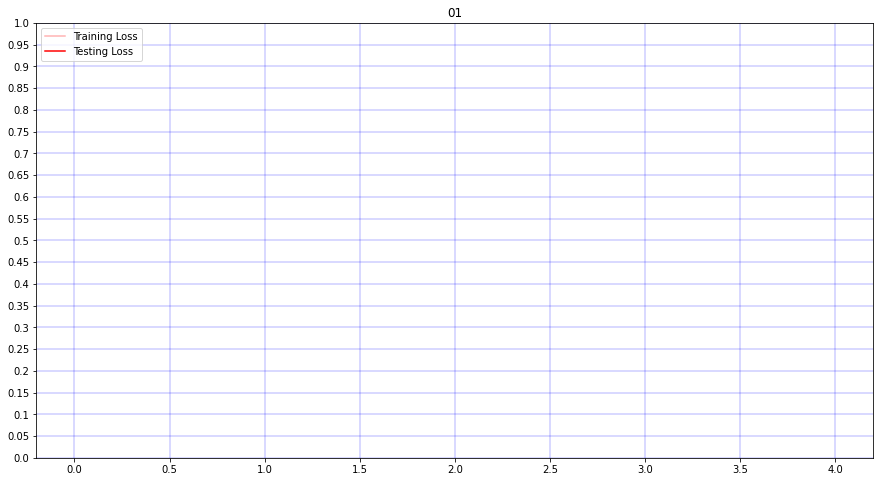

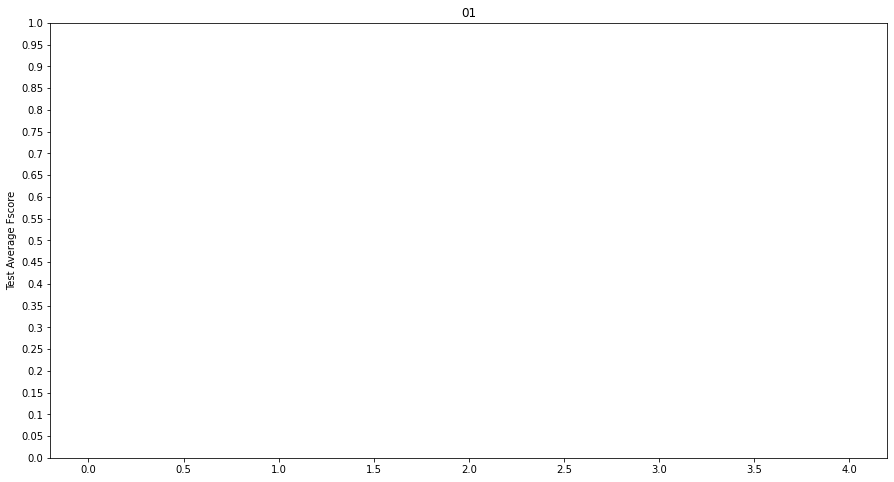

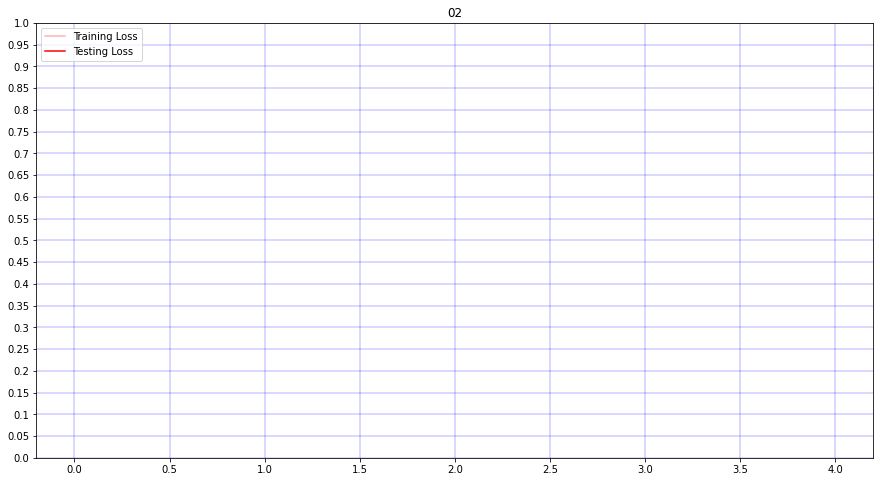

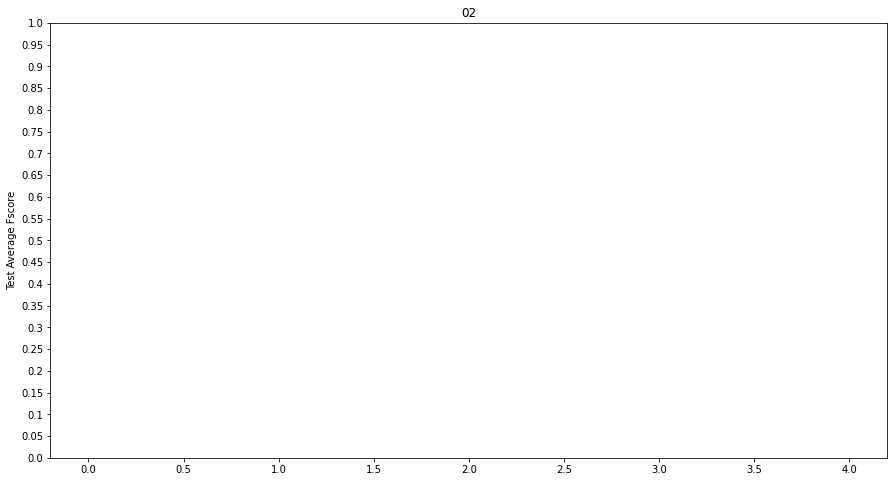

In [5]:
#@title
# LOPO
print('Cuda available? ', torch.cuda.is_available())

P = 15
win_size = 10
hop = .5

participants = []


if os.path.exists('../Data/rawAudioSegmentedData_window_' + str(win_size) + '_hop_' + str(hop) + '_Test.pkl'):
    print('loading pkl file')
    with open('../Data/rawAudioSegmentedData_window_' + str(win_size) + '_hop_' + str(hop) + '_Test.pkl', 'rb') as f:
        participants = pickle.load(f)
else:

    start = time.time()
    for j in range (1, P+1):
        pname = str(j).zfill(2)
        p = parti(pname, '../Data',win_size, hop, normalized = False)
        p.readRawAudioMotionData()
        participants.append(p)
        print('participant',j,'data read...')
    end = time.time()
    print("time for feature extraction: " + str(end - start))

    with open('../Data/rawAudioSegmentedData_window_' + str(win_size) + '_hop_' + str(hop) + '_Test.pkl', 'wb') as f:
        pickle.dump(participants, f)

#model_name = 'DeepConvLSTM_MotionAudio_CNN14_Concatenate'
model_name = 'AttendDiscriminate_MotionAudio_CNN14_Concatenate'
experiment = f'LOPO+1_{model_name}'

config_model = {
    "model": model_name,
    "input_dim": 6,
    "hidden_dim": 128,
    "filter_num": 64,
    "filter_size": 5,
    "enc_num_layers": 2,
    "enc_is_bidirectional": False,
    "dropout": .5,
    "dropout_rnn": .25,
    "dropout_cls": .5,
    "activation": "ReLU",
    "sa_div": 1,
    "num_class": 23,
    "train_mode": True,
    "experiment": experiment,
    "window_size": 1024,
    "hop_size": 320,
    "fmin": 50, 
    "fmax": 11000,
    "mel_bins": 64,
    "sample_rate": 22050
}

results_path = './performance_results/{}/{}/'.format(experiment,model_name)
if not os.path.exists(results_path):
    os.makedirs(results_path)

file = open(results_path + 'performance_results.csv', "w")
results = csv.writer(file)
results.writerow(["Participant", "Precision", "Recall", "F-Score", "Accuracy"])

args = copy.deepcopy(config_model)

i_p = 1
for u in participants:
    if i_p == 3:
      print('Stop at 4 participants, crashes otherwise.')
      break
    i_p += 1
                
    print("participant : " + u.name)
    args['participant'] = u.name
    config_model['participant'] = u.name

    X_trainM = np.empty((0,np.shape(u.rawMdataX_s1)[1], np.shape(u.rawMdataX_s1)[-1]))
    X_trainA = np.empty((0,np.shape(u.rawAdataX_s1)[-1]))
    y_train = np.zeros((0, 1))

    # limit to just 4 participants b/c running out of memory
    i_partic = 1
    for x in participants:
        if x != u:
            if i_partic == 4:
              print('Stop at 4 participants, crashes otherwise.')
              break
            i_partic += 1

            print("Adding data for Participant: " + x.name)
            X_trainM = np.vstack((X_trainM, x.rawMdataX_s1[:]))
            X_trainM = np.vstack((X_trainM, x.rawMdataX_s2[:]))
            X_trainA = np.vstack((X_trainA, x.rawAdataX_s1[:]))
            X_trainA = np.vstack((X_trainA, x.rawAdataX_s2[:]))
            y_train = np.vstack((y_train, x.rawdataY_s1))
            y_train = np.vstack((y_train, x.rawdataY_s2))

    X_trainM = np.vstack((X_trainM,u.rawMdataX_s1[:]))
    X_trainA = np.vstack((X_trainA,u.rawAdataX_s1[:]))
    y_train = np.vstack((y_train,u.rawdataY_s1))
    
    labels = np.array(u.labels)
    X_testM = copy.deepcopy(u.rawMdataX_s2[:])
    y_test = copy.deepcopy(u.rawdataY_s2)
    X_testA= copy.deepcopy(u.rawAdataX_s2[:])

    X_testA = X_testA[(y_test != 23)[:,0]]


    X_testM = X_testM[(y_test != 23)[:,0]]
    X_testA = X_testA[(y_test != 23)[:,0]]

    y_test = y_test[y_test != 23]

    X_trainM = X_trainM[(y_train != 23)[:,0]]
    X_trainA = X_trainA[(y_train != 23)[:,0]]

    y_train = y_train[y_train != 23]


    classes = np.unique(y_test).astype(int)
    # 
    # y_train = tf.keras.utils.to_categorical(y_train, num_classes=23, dtype='int32')
    # y_test = tf.keras.utils.to_categorical(y_test, num_classes=23, dtype='int32')
    
    #import pdb; pdb.set_trace()
    torch.cuda.empty_cache()

    # [STEP 3] create HAR models
    if torch.cuda.is_available():
        model = create(model_name, config_model).cuda()
        torch.backends.cudnn.benchmark = True
        sys.stdout = Logger(
            os.path.join(model.path_logs, f"log_main_{experiment}.txt")
        )
    args['batch_size']= 64
    args['optimizer']= 'Adam'
    args['clip_grad']= 0
    args['lr']= 0.001
    args['lr_decay']= 0.9
    args['lr_step']= 10
    args['mixup']= True
    args['alpha']= 0.8
    args['lr_cent']= 0.001
    args['beta']= 0.003
    args['print_freq']= 40
    args['init_weights'] = None
    args['epochs'] = 5
    #args['epochs'] = 100
    args['class_map'] = [chr(a+97).upper() for a in list(range(23))]

    # show args
    print("##" * 50)
    print(paint(f"Experiment: {model.experiment}", "blue"))
    print(
        paint(
            f"[-] Using {torch.cuda.device_count()} GPU: {torch.cuda.is_available()}"
        )
    )
    # commenting out below to save output space
    #get_info_params(model)
    #get_info_layers(model)
    print("##" * 50)

    statistics_path = './statistics/LOPO/{}/participant_{}/batch_size={}/statistics.pkl'.format(
                model_name,u.name, args['batch_size'])
    if not os.path.exists(os.path.dirname(statistics_path)):
        os.makedirs(os.path.dirname(statistics_path))


    # Statistics
    statistics_container = StatisticsContainer(statistics_path)
    args['statistics'] = statistics_container

    x_trainM_tensor = torch.from_numpy(np.array(X_trainM)).float()
    x_trainA_tensor = torch.from_numpy(np.array(X_trainA)).float()
    y_train_tensor = torch.from_numpy(np.array(y_train)).long()

    x_testM_tensor = torch.from_numpy(np.array(X_testM)).float()
    x_testA_tensor = torch.from_numpy(np.array(X_testA)).float()
    y_test_tensor = torch.from_numpy(np.array(y_test)).long()

    x_valM_tensor = torch.from_numpy(np.array(X_testM)).float()
    x_valA_tensor = torch.from_numpy(np.array(X_testA)).float()
    y_val_tensor = torch.from_numpy(np.array(y_test)).long()

    train_data = TensorDataset(x_trainM_tensor, x_trainA_tensor, y_train_tensor)
    test_data = TensorDataset(x_testM_tensor, x_testA_tensor, y_test_tensor)
    val_data = TensorDataset(x_valM_tensor, x_valA_tensor, y_val_tensor)

    # [STEP 4] train HAR models
    model_train(model, train_data, val_data, args)

    # [STEP 5] evaluate HAR models
    if not config_model['train_mode']:
        config_model["experiment"] = "inference_LOPO"
        model = create(model_name, config_model).cuda()
    model_eval(model, test_data, args)
    plotCNNStatistics(statistics_path, u)

    del train_data, test_data, val_data, model, 
file.close()


plt.show()


#print(np.shape(X_trainA), np.shape(X_testA), np.shape(y_train))